# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

data x shape: (5000, 30, 8)
data y shape: (5000, 30, 1)


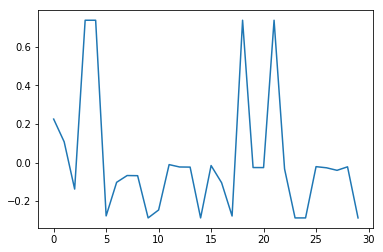

In [3]:
BATCH_SIZE=5000
TIME_SERIES_LENGTH = 30

def g1(x):
    return 1/(np.e * (x+0.023))

def g2(x):
    return -1/(x+0.02)

def g3(x):
    return 1/(x + 1.7)

def g4(x):
    return 3

def g5(x):
    return -1

def create_data(batch_size=1000, time_series_length=500):
    funcs = [np.sin, np.cos, g1, g2, g3, g4, g5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, func_count + 1))
    y_data = np.zeros((batch_size, time_series_length, 1))
    
    for batch_idx in range(batch_size):
        x = np.zeros((time_series_length, func_count+1), dtype=np.float16)
        y = np.zeros((time_series_length, 1))
        for t in range(time_series_length):
            selected_func_idx = np.random.randint(func_count)
            
            x[t, 0] = t/time_series_length
            x[t, selected_func_idx + 1] = 1
            y[t, 0] = funcs[selected_func_idx](t)
        
        x_data[batch_idx, :] = x
        y_data[batch_idx, :] = y
    
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)

# Scaling
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)
plot(data_y[0])

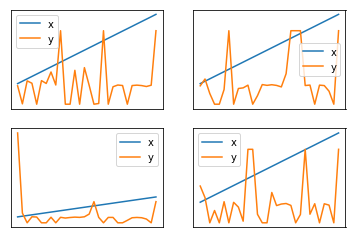

In [6]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
            sample_y = data_y[batch_idx]
                                    
            sample_x = sample_x[:, 0].reshape((-1, 1))
            
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x, label='x')
            sp.plot(tick_x, sample_y, label='y')
            sp.legend()

visualize(data_x, data_y)

## Model

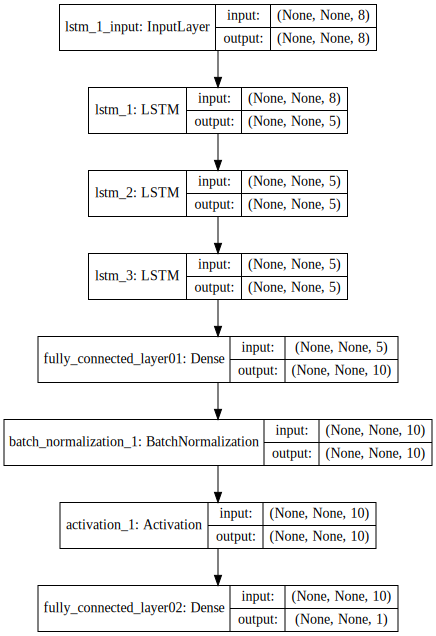

In [7]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, 8), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [ ]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


# Grid Search 
params = dict(lstm_out1=[1, 4, 6, 10, 20, 50, 100], 
              lstm_out2=[None, 4, 6, 10, 20, 100], 
              lstm_out3=[None, 4, 6, 10, 20, 100], 
              optimizer=['adam'], 
              nb_epoch=[30, 200])

classifier = KerasRegressor(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer, n_jobs=1)
grid_result = grid.fit(X=data_x, y=data_y)

error:0.9311342615786549, score:0.07817997538455923
error:0.9163804572449392, score:0.07895236105238568
error:0.31095936531420015, score:0.6801578204652571
error:0.3107998050428667, score:0.6934531949317241
error:0.34206862551535344, score:0.663860378094901
error:0.3382513206735442, score:0.6587407854169831
error:0.8693935414821076, score:0.13930309636464433
error:0.8558105224767423, score:0.1398307822020276
error:0.36614872148160454, score:0.6233919342027032
error:0.36273071819238933, score:0.6422329069779764
error:0.21431603757455653, score:0.7893986572724221
error:0.20435610607659627, score:0.7938266608506478
error:1.880101080065185, score:-0.8612942251387726
error:1.8749547133368079, score:-0.8845039723397102
error:0.7633453886800038, score:0.21484901216429575
error:0.7635848848194091, score:0.24686404868390166
error:0.7523866886643324, score:0.26065427171803945
error:0.7433186157156981, score:0.2500714365905078
error:1.8072063181948788, score:-0.7891286374740059
error:1.8172515786

error:0.8271007348174021, score:0.18421735273312656
error:2.160821381763879, score:-1.1233683187877253
error:2.123730156642261, score:-1.1426153896424092
error:0.43484934508978496, score:0.569500500051342
error:0.43284433154991603, score:0.5649511658023628
error:0.40218443526409575, score:0.5863268301315128
error:0.39690665579947043, score:0.6085246345991746
error:0.43712625252756165, score:0.5704503649580912
error:0.43521373452674494, score:0.560916135006964
error:0.9471394177533302, score:0.06233492052222466
error:0.9385313291031083, score:0.05668867344938333
error:0.1330128423306154, score:0.8631875346344733
error:0.1226444129611814, score:0.8790338592794839
error:2.264350987844335, score:-1.225103467959734
error:2.2431558036753545, score:-1.2631030271375958
error:4.733050412966734, score:-3.6857051965739136
error:4.736315216867902, score:-3.760437559878932
error:1.0753585474663134, score:-0.10607706333401934
error:1.1197998780421679, score:-0.10447648087271588
error:1.1004081111458

error:0.2641556291195546, score:0.7384867482757471
error:0.2633004688570159, score:0.7353585257550584
error:0.9753511950534837, score:-0.003212917297128915
error:0.9683907725251204, score:0.044860734921530754
error:0.054147011946767194, score:0.9467915068338816
error:0.05293803992898596, score:0.9465912094836556
error:0.9173610849347721, score:0.09181537744931755
error:0.9145202346273352, score:0.08082205789752817
error:0.16112811739122446, score:0.8342691232384448
error:0.1628326253713497, score:0.8393955843647258
error:0.092315012617253, score:0.9092850640991187
error:0.09113903382168786, score:0.9080505139258224
error:0.2017720057119248, score:0.8002463415353966
error:0.20569794132290992, score:0.7932544264841181
error:2.414338771295021, score:-1.4833063765935384
error:2.4210543523830075, score:-1.387924524332608
error:0.30830897745272656, score:0.6970348772712693
error:0.3069992993847491, score:0.6902707147544624
error:0.4273774712696325, score:0.5768976319076426
error:0.4258289231

In [ ]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

## Training

In [ ]:
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, epochs=300)

/usr/local/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/300
9s - loss: 0.5483 - mean_squared_error: 0.5483
Epoch 2/300
8s - loss: 0.0451 - mean_squared_error: 0.0451
Epoch 3/300
8s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 4/300
8s - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 5/300
8s - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 6/300
8s - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 7/300
8s - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 8/300
8s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 9/300
7s - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 10/300
7s - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 11/300
8s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 12/300
8s - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 13/300


error:0.006668408387746592, score:0.9933315916122533
score: 0.993331591612


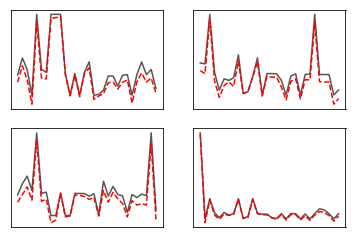

In [43]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')


visualize_prediction(data_x, data_y)

# Test

### test1

```
model = create_model(lstm_out1=5, lstm_out2=5, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, nb_epoch=300)

error:0.37757520777163645, score:0.6224247922283634
score: 0.622424792228
```

### Test2
test2 is better than test1 when I see the graph

```
model = create_model(lstm_out1=10, lstm_out2=10, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, nb_epoch=300)

error:0.011633959443667232, score:0.9883660405563328
score: 0.988366040556
```

### Test3 

```
model = create_model(lstm_out1=10, lstm_out2=None, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, nb_epoch=300)

error:0.01429974707712619, score:0.9857002529228739
score: 0.985700252923
```


### Test4

```
model = create_model(lstm_out1=20, lstm_out2=20, lstm_out3=None, dense1=1024)
model.fit(data_x, data_y, verbose=2, nb_epoch=300)

error:0.006668408387746592, score:0.9933315916122533
score: 0.993331591612
```